## Preparación de Datos (Accidentes) parte 4: Finding conflict zones in the city
El objetivo del proyecto es predecir la cantidad de accidentes en la ciudad de Barranquilla, para ser más específico en esta tarea dividir la ciudad por zonas de conflicto es la mejor opción. Dado que Barranquilla es una ciudad con demografía variada predecir la cantidad de accidentes a partir de los puntos clave que siguen patrones en común ayudará a la precisión de la predicción objetivo.

Inicialmente, mediante la implementación de un algoritmo de clustering llamado K-Means se tratará de encontrar automáticamente las fronteras de las zonas. La cantidad *K* de zonas a dividir intentará encontrarse con el método de Elbow.

### Lectura del último dataset
Se crea el DataFrame a partir de la ultima transformación (añadiendo el momento del día del accidente).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Accidentes_momento_dia.csv')
df['FECHA_ACCIDENTE'] = pd.to_datetime(df['FECHA_ACCIDENTE'], format="%Y-%m-%d %H:%M:%S")
df.head(10)

,FECHA_ACCIDENTE,AÑO_ACCIDENTE,MES_ACCIDENTE,DIA_ACCIDENTE,HORA_ACCIDENTE,MOMENTO_DIA,GRAVEDAD_ACCIDENTE,CLASE_ACCIDENTE,SITIO_EXACTO_ACCIDENTE,LATITUD,LONGITUD,CANT_HERIDOS_EN _SITIO_ACCIDENTE,CANT_MUERTOS_EN _SITIO_ACCIDENTE,CANTIDAD_ACCIDENTES
0,2017-12-24 21:30:00,2017,12,Dom,09:30:00:PM,Noche,Con heridos,Choque,CR 6 CL 94,10.946586,-74.826513,1.0,0.0,1
1,2015-01-01 14:10:00,2015,1,Jue,02:10:00:PM,Tarde,Con heridos,Choque,VIA 40 CON 77,11.016189,-74.795327,1.0,0.0,1
2,2015-01-01 14:15:00,2015,1,Jue,02:15:00:PM,Tarde,Solo daños,Choque,CALLE 14 CR 13,10.952965,-74.771882,0.0,0.0,1
3,2015-01-01 14:20:00,2015,1,Jue,02:20:00:PM,Tarde,Solo daños,Choque,CL 74 CR 38C,10.985707,-74.812420,0.0,0.0,1
4,2015-01-01 15:30:00,2015,1,Jue,03:30:00:PM,Tarde,Con heridos,Choque,CL 45 CR 19,10.958396,-74.794710,2.0,0.0,1
5,2015-01-01 04:20:00,2015,1,Jue,04:20:00:AM,Madrugada,Solo daños,Choque,CRA 15 CLLE 21,10.953501,-74.776203,0.0,0.0,1
6,2015-01-01 16:40:00,2015,1,Jue,04:40:00:PM,Tarde,Con heridos,Choque,CRA 14 CLLE 35,10.951457,-74.788801,2.0,0.0,1
7,2015-01-01 16:50:00,2015,1,Jue,04:50:00:PM,Tarde,Con heridos,Atropello,CRA 6 CLLE 90,10.944943,-74.823909,1.0,0.0,1
8,2015-01-01 06:00:00,2015,1,Jue,06:00:00:AM,Mañana,Solo daños,Choque,CRA 6 CLLE 92,10.944446,-74.825528,0.0,0.0,1
9,2015-01-01 19:50:00,2015,1,Jue,07:50:00:PM,Noche,Solo daños,Choque,CALLE 99 CR 56,11.016135,-74.826478,0.0,0.0,1


### Método de Elbow
Para llevar a cabo el método de clustering con K-Means se tomarán unicamente la latitud y la longitud del accidente, la intención es que el algoritmo pueda encontrar las zonas a partir de la distancia que tienen los accidentes en la ciudad.

El método de elbow consiste en formar los clusters con K-Means con un intervalo de valores para el número de clusters *K*. Al graficar la distorción del dataset para cada número de clusters se espera obtener una línea en forma de brazo, el valor *K* óptimo será el primer punto de quiebre de la gráfica, es decir, el codo para la analogía del brazo.

![Ejemplo del método con k ótimo de 3](https://pythonprogramminglanguage.com/wp-content/uploads/2017/07/elbow-method.png "Elbow method example")

En la imágen anterior por ejemplo, el valor *K* óptimo sería 3. De forma más formal, el número de clusters óptimo se define cómo el punto en que la grán mayoria de la varianza es explicada, a partir de dicho punto la varianza de los datos incrementa muy poco conforme se aumenta el número de clusters para K-Means.

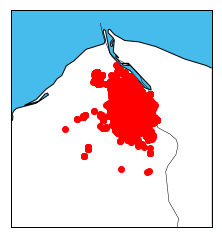

In [2]:
def plot_coordinates(lat,lon):
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap

    # determine range to print based on min, max lat and lon of the data
    margin = 0.1 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'h',
                area_thresh=10000.,
                )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color = 'white',lake_color='#46bcec')
    # convert lat and lon to map projection coordinates
    lons, lats = m(lon, lat)
    # plot points as red dots
    m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
    plt.show()

lat = df.iloc[:, 9:10].values # latitude
lng = df.iloc[:, 10:11].values # longitude
plot_coordinates(lat,lng)

K-means buscará agrupar los puntos de la gráfica anterior a partir de su cercanía. A continuación se ejecuta el método de Elbow.

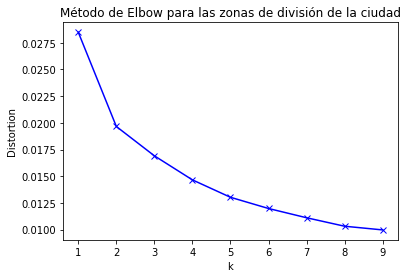

In [3]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

plt.plot()
X = np.array(list(zip(lat, lng))).reshape(len(lat), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Método de Elbow para las zonas de división de la ciudad')
plt.show()

A partir del gráfico el valor *K* óptimo parece estar entre 2 y 3 zonas, a continuación se visualizará cada punto con un color correspondiente a su zona para estos dos casos.

### Usando dos clusters

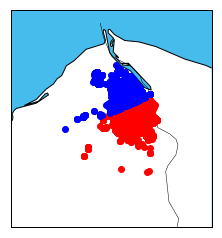

In [4]:
# In case of KeyError: 'PROJ_LIB', the path is the "share" folder of the python environment
# import os
# os.environ["PROJ_LIB"] = "C:\\Users\\danie\\AppData\\Local\\conda\\conda\\envs\\tf_gpu\\Library\\share";
from mpl_toolkits.basemap import Basemap
k = 2;
X = np.array(list(zip(lng, lat))).reshape(len(lng), 2)
kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
cluster = kmeanModel.predict(X)
cluster_df = pd.DataFrame()
cluster_df['LONGITUDE'] = df['LONGITUD']
cluster_df['LATITUDE'] = df['LATITUD']
cluster_df['CLUSTER'] = cluster

lon0 = cluster_df[cluster_df['CLUSTER'] == 0]['LONGITUDE'].values; lat0 = cluster_df[cluster_df['CLUSTER'] == 0]['LATITUDE'].values
lon1 = cluster_df[cluster_df['CLUSTER'] == 1]['LONGITUDE'].values; lat1 = cluster_df[cluster_df['CLUSTER'] == 1]['LATITUDE'].values

# determine range to print based on min, max lat and lon of the data
margin = 0.1 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lng) - margin
lon_max = max(lng) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons0, lats0 = m(lon0, lat0)
lons1, lats1 = m(lon1, lat1)
# plot points as red dots
m.scatter(lons0, lats0, marker = 'o', color='r', zorder=5)
m.scatter(lons1, lats1, marker = 'o', color='b', zorder=5)
plt.show()

Con dos zonas los accidentes se dividen básicamente en el norte y el sur de la ciudad, con una mayor concentración en el sur. Aunque parece una buena división de la ciudad, el valor de la distorción entre los dos centros de cada grupo es de 0.02 que sigue siendo un valor bastante alto para la cercania de los coordenadas.
### Usando tres clusters

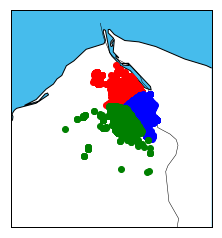

In [5]:
# In case of KeyError: 'PROJ_LIB', the path is the "share" folder of the python environment
# import os
# os.environ["PROJ_LIB"] = "C:\\Users\\danie\\AppData\\Local\\conda\\conda\\envs\\tf_gpu\\Library\\share";
from mpl_toolkits.basemap import Basemap
k = 3;
X = np.array(list(zip(lng, lat))).reshape(len(lng), 2)
kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
cluster = kmeanModel.predict(X)
cluster_df = pd.DataFrame()
cluster_df['LONGITUDE'] = df['LONGITUD']
cluster_df['LATITUDE'] = df['LATITUD']
cluster_df['CLUSTER'] = cluster

lon0 = cluster_df[cluster_df['CLUSTER'] == 0]['LONGITUDE'].values; lat0 = cluster_df[cluster_df['CLUSTER'] == 0]['LATITUDE'].values
lon1 = cluster_df[cluster_df['CLUSTER'] == 1]['LONGITUDE'].values; lat1 = cluster_df[cluster_df['CLUSTER'] == 1]['LATITUDE'].values
lon2 = cluster_df[cluster_df['CLUSTER'] == 2]['LONGITUDE'].values; lat2 = cluster_df[cluster_df['CLUSTER'] == 2]['LATITUDE'].values

# determine range to print based on min, max lat and lon of the data
margin = 0.1 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lng) - margin
lon_max = max(lng) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons0, lats0 = m(lon0, lat0)
lons1, lats1 = m(lon1, lat1)
lons2, lats2 = m(lon2, lat2)
# plot points as red dots
m.scatter(lons0, lats0, marker = 'o', color='r', zorder=5)
m.scatter(lons1, lats1, marker = 'o', color='b', zorder=5)
m.scatter(lons2, lats2, marker = 'o', color='g', zorder=5)
plt.show()

Cuando se utiliza un valor de *K* = 3 se obtienen la zonas que se muestran en la imagen anterior, con este número de zonas se nota una clara diferenciación entre el norte, el sur y el centro de la ciudad. La distorción con esta cantidad de grupos es de aproximadamente 0.01625 y teniendo en cuenta la demografía de la ciudad parece ser una mejor representación de la movilidad por la ciudad. Antes de decidir si trabajar con estas tres zonas es la mejor opción, es importante analizar la cantidad de accidentes que hay en cada zona, la proporcion debe tener una proporción similar ya que cada zona se utilizará para construir un modelo diferente.

In [7]:
print('La zona norte (color rojo) tiene {0} accidentes registrados.\nLa zona centro (color azul) tiene {1} accidentes registrados.\nLa zona sur (color verde) tiene {2} accidentes registrados.'
      .format(cluster_df[cluster_df['CLUSTER'] == 0].shape[0], cluster_df[cluster_df['CLUSTER'] == 1].shape[0], cluster_df[cluster_df['CLUSTER'] == 2].shape[0]))

La zona norte (color rojo) tiene 12578 accidentes registrados.
La zona centro (color azul) tiene 8612 accidentes registrados.
La zona sur (color verde) tiene 3661 accidentes registrados.


Las zonas aunque tienen una gran concentración en el norte, parece estar bien balanceada para la construcción de un modelo por zona.

### Graficas de clusters
La gráfica dinámica a continuación permite explorar y visualizar los clusters de forma más sencilla.


In [8]:
%%html
<div class='tableauPlaceholder' id='viz1547940912275' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ac&#47;AccidentesBarranquillaCluster&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='AccidentesBarranquillaCluster&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ac&#47;AccidentesBarranquillaCluster&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1547940912275');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Finalmente se agrega la información de los cluster al dataset.

In [8]:
clusters_data = cluster_df['CLUSTER'].values
df['ZONA'] = clusters_data
encode = {'ZONA' : {0 : 'NORTE', 1 : 'CENTRO', 2 : 'SUR'}}
df.replace(encode, inplace=True)
df.head(10)

,FECHA_ACCIDENTE,AÑO_ACCIDENTE,MES_ACCIDENTE,DIA_ACCIDENTE,HORA_ACCIDENTE,MOMENTO_DIA,GRAVEDAD_ACCIDENTE,CLASE_ACCIDENTE,SITIO_EXACTO_ACCIDENTE,LATITUD,LONGITUD,CANT_HERIDOS_EN _SITIO_ACCIDENTE,CANT_MUERTOS_EN _SITIO_ACCIDENTE,CANTIDAD_ACCIDENTES,ZONA
0,2017-12-24 21:30:00,2017,12,Dom,09:30:00:PM,Noche,Con heridos,Choque,CR 6 CL 94,10.946586,-74.826513,1.0,0.0,1,SUR
1,2015-01-01 14:10:00,2015,1,Jue,02:10:00:PM,Tarde,Con heridos,Choque,VIA 40 CON 77,11.016189,-74.795327,1.0,0.0,1,NORTE
2,2015-01-01 14:15:00,2015,1,Jue,02:15:00:PM,Tarde,Solo daños,Choque,CALLE 14 CR 13,10.952965,-74.771882,0.0,0.0,1,CENTRO
3,2015-01-01 14:20:00,2015,1,Jue,02:20:00:PM,Tarde,Solo daños,Choque,CL 74 CR 38C,10.985707,-74.812420,0.0,0.0,1,NORTE
4,2015-01-01 15:30:00,2015,1,Jue,03:30:00:PM,Tarde,Con heridos,Choque,CL 45 CR 19,10.958396,-74.794710,2.0,0.0,1,CENTRO
5,2015-01-01 04:20:00,2015,1,Jue,04:20:00:AM,Madrugada,Solo daños,Choque,CRA 15 CLLE 21,10.953501,-74.776203,0.0,0.0,1,CENTRO
6,2015-01-01 16:40:00,2015,1,Jue,04:40:00:PM,Tarde,Con heridos,Choque,CRA 14 CLLE 35,10.951457,-74.788801,2.0,0.0,1,CENTRO
7,2015-01-01 16:50:00,2015,1,Jue,04:50:00:PM,Tarde,Con heridos,Atropello,CRA 6 CLLE 90,10.944943,-74.823909,1.0,0.0,1,SUR
8,2015-01-01 06:00:00,2015,1,Jue,06:00:00:AM,Mañana,Solo daños,Choque,CRA 6 CLLE 92,10.944446,-74.825528,0.0,0.0,1,SUR
9,2015-01-01 19:50:00,2015,1,Jue,07:50:00:PM,Noche,Solo daños,Choque,CALLE 99 CR 56,11.016135,-74.826478,0.0,0.0,1,NORTE


Y se guarda el estado actual de los datos para posterior uso.

In [9]:
df.to_csv('Accidentes_clusters.csv', index=False)